In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("netflix_titles.csv")
df['listed_in'] = df['listed_in'].fillna('')
df['type'] = df['type'].fillna('')
df['rating'] = df['rating'].fillna('')
df['country'] = df['country'].fillna('')
df['cast'] = df['cast'].fillna('')

df['features'] = df.apply(lambda row: f"{row['listed_in']} {row['type']} {row['rating']} {row['country']} {row['cast']}", axis=1)

In [3]:
features = list(set(word for features in df['features'] for word in features.split()))
index = {feature: idx for idx, feature in enumerate(features)}

bow = []
for features in df['features']:
    row = [0] * len(index)
    for feature in features.split():
        if feature in index:
            row[index[feature]] = 1
    bow.append(row)

bow_array = np.array(bow)

In [4]:
cosine_sim = cosine_similarity(bow_array, bow_array)
titles = ["Naruto", "Narcos", "Breaking Bad"]
query = df[df['title'].isin(titles)].index

for query_idx in query:
    query_distances = []
    for i in range(len(df)):
        similarity = cosine_sim[query_idx][i]
        query_distances.append((i, similarity))
    query_distances = sorted(query_distances, key=lambda x: x[1], reverse=True)
    print(f"\nTop 10 titles similar to '{df.iloc[query_idx]['title']}':")
    for similar, score in query_distances[1:11]:
        print(f"{df.iloc[similar]['title']} - {score:.4f}")


Top 10 titles similar to 'Naruto':
Pop Team Epic - 0.5774
Marvel Anime: Wolverine - 0.4352
Bleach - 0.4352
Naruto Shippûden the Movie: Bonds - 0.4330
Naruto Shippuden the Movie: Blood Prison - 0.4170
Naruto Shippuden : Blood Prison - 0.4170
Naruto the Movie: Ninja Clash in the Land of Snow - 0.4099
Pioneers: First Women Filmmakers* - 0.4082
Aggretsuko - 0.4009
忍者ハットリくん - 0.3858

Top 10 titles similar to 'Narcos':
Narcos: Mexico - 0.3126
L.A.’s Finest - 0.2359
El Cartel - 0.2345
Marvel's Iron Fist - 0.2270
Wild District - 0.2231
Queen of the South - 0.2190
El Dragón: Return of a Warrior - 0.2188
Cocaine Cowboys: The Kings of Miami - 0.2154
The Sons of Sam: A Descent into Darkness - 0.2154
Jeffrey Epstein: Filthy Rich - 0.2154

Top 10 titles similar to 'Breaking Bad':
Better Call Saul - 0.5449
Killer Inside: The Mind of Aaron Hernandez - 0.4619
Cocaine Cowboys: The Kings of Miami - 0.4518
The Sons of Sam: A Descent into Darkness - 0.4518
Jeffrey Epstein: Filthy Rich - 0.4518
Crime Scene

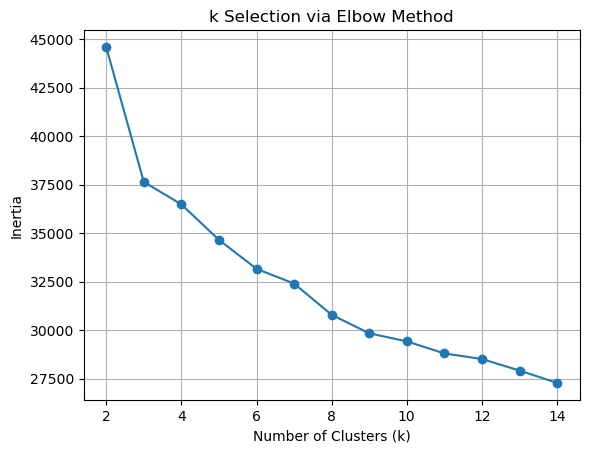

In [5]:
pca = PCA(n_components=50, random_state=42)
bow_reduced = pca.fit_transform(bow_array)

inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(bow_reduced)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.title('k Selection via Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [6]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
df['cluster'] = kmeans.fit_predict(bow_reduced)

print("Number of movies per cluster:")
print(df["cluster"].value_counts().sort_index())

for cluster_num in range(k):
    print(f"\nSample titles from Cluster {cluster_num}:")
    cluster_titles = df[df['cluster'] == cluster_num]['title']
    sample = cluster_titles.sample(n=5, random_state=42) if len(cluster_titles) >= 5 else cluster_titles
    print(sample.to_list())

Number of movies per cluster:
cluster
0     920
1     831
2    1378
3    1274
4     628
5     427
6     492
7    1271
8     725
9     861
Name: count, dtype: int64

Sample titles from Cluster 0:
['Mercy Black', 'Newness', 'Crash', 'A Single Man', 'Christian Mingle']

Sample titles from Cluster 1:
['Being AP', 'Unruly Friends', 'LA Originals', '100 Meters', 'Alice Junior']

Sample titles from Cluster 2:
['Interior Design Masters', 'Hyper HardBoiled Gourmet Report', 'Humsafar', 'Call Me Francis', 'Black Money Love']

Sample titles from Cluster 3:
['Christmas in the Heartland', 'Long Shot', 'Bully', 'Cristela Alonzo: Lower Classy', 'Sommore: Chandelier Status']

Sample titles from Cluster 4:
['Tayo the Little Bus Movie: Mission Ace', 'The Croods', 'Norm of the North: Keys to the Kingdom', 'Thomas & Friends: Marvelous Machinery: World of Tomorrow', 'Hotel Transylvania 3: Summer Vacation']

Sample titles from Cluster 5:
['Train to Busan', 'The Suit', 'Hajwala 2: Mysterious Mission', 'Brick 